In [1]:
 %matplotlib inline
import pandas as pd
import datetime
from scipy import interpolate
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
base_date = '20180731'

In [3]:
root_path = '/Users/susynishida/Desktop/dev/Python/Finance/discount_factor/'

In [4]:
IR_input = '/IR.csv'

In [5]:
df_IR = pd.read_csv(root_path + 'input/' + base_date + IR_input)

In [6]:
df_IR['Tenor'].apply(lambda x: df_IR['Rate'][df_IR.query('Tenor == @x').index[0]] if x=='O/N' else 0)

0     0.019154
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
Name: Tenor, dtype: float64

In [29]:
df_IR.query('Product == "LIBOR"')

,Date,Product,Tenor,Currency,Rate,lag(day),Frequency(month),Dcc
0,2018/7/31,LIBOR,O/N,USD,0.019154,2,NaN,ACT/360
1,2018/7/31,LIBOR,1W,USD,0.019536,2,NaN,ACT/360
2,2018/7/31,LIBOR,1M,USD,0.020814,2,NaN,ACT/360
3,2018/7/31,LIBOR,2M,USD,0.021791,2,NaN,ACT/360
4,2018/7/31,LIBOR,3M,USD,0.023486,2,NaN,ACT/360
5,2018/7/31,LIBOR,6M,USD,0.025305,2,NaN,ACT/360
6,2018/7/31,LIBOR,9M,USD,0.026042,2,NaN,ACT/360


In [8]:
df_IR.set_index('Tenor').at['O/N', 'Rate']

0.0191538

In [9]:
df_IR.at[df_IR.query('Product == "SWAP"')['Frequency(month)'].index[0], 'Frequency(month)']

3.0

In [10]:
df_IR.query('Tenor == "1Y"').index

Int64Index([7], dtype='int64')

In [11]:
list(df_IR['Tenor'][0:3])

['O/N', '1W', '1M']

## function: library

In [12]:
def tenor_to_days(str_tenor):
    if(str_tenor=='O/N'):
        days = 1
    elif(str_tenor=='T/N'):
        days = 2
    elif(str_tenor[-1]=='W'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 7
    elif(str_tenor[-1]=='M'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 30
    elif(str_tenor[-1]=='Y'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 365
    return days

def str_dcc_to_num(str_dcc):
    if(str_dcc=='ACT/360'):
        dcc_num = 360
    elif(str_dcc=='ACT/365F'):
        dcc_num = 365
    return dcc_num

def interpolation(array_x, array_y, str_kind):
    f = interpolate.interp1d(array_x, array_y, kind=str_kind)
    return f

## class: calc discount factor

In [326]:
class discount_factor():
    def __init__(self, df, str_ccy):
        self._df_ir = df[df['Currency']==str_ccy]
        self._base_date_obj = datetime.datetime.strptime(self._df_ir['Date'][0], '%Y/%m/%d')
        self._spot_date = self._base_date_obj + datetime.timedelta(days=int(self._df_ir['lag(day)'][0]))
        self._frequency_year = (self._df_ir.at[self._df_ir.query('Product == "SWAP"')['Frequency(month)'].index[0], 'Frequency(month)']) /12
        self._str_frequency = str(int(self._df_ir.at[self._df_ir.query('Product == "SWAP"')['Frequency(month)'].index[0], 'Frequency(month)'])) + 'M'
        
    def get_raw_rate(self, str_tenor):
        return self._df_ir.set_index('Tenor').at[str_tenor, 'Rate']

    def calc_DF_short_term(self, str_tenor):
        short_term_rate = self.get_raw_rate(str_tenor)
        dcc = str_dcc_to_num(self._df_ir.set_index('Tenor').at[str_tenor, 'Dcc'])
        target_date_obj = self._base_date_obj + datetime.timedelta(days = int(tenor_to_days(str_tenor)))
        dfc = (target_date_obj - self._base_date_obj).days / dcc
        DF = 1 / ( 1 + dfc * short_term_rate)
        return DF
    
    def get_str_frequency(self):
        return self._str_frequency
    
    def get_array_swap_tenor(self):
        index_one_year = self._df_ir.query('Tenor == "1Y"').index[0]
        array_swap_tenor = self._df_ir['Tenor'][index_one_year:].apply(lambda x: int(x[0:len(x)-1]))
        list_array_swap_tenor = list(array_swap_tenor)
        return list_array_swap_tenor
    
    def get_array_swap_rate(self):
        index_one_year = self._df_ir.query('Tenor == "1Y"').index[0]
        array_swap_rate = self._df_ir['Rate'][index_one_year:]
        list_array_swap_rate = list(array_swap_rate.map(lambda x: float(x)))
        return list_array_swap_rate
    
    def interpolation_swap_rate(self, kind):
        array_x = self.get_array_swap_tenor()
        array_y = self.get_array_swap_rate()
        func = interpolation(array_x, array_y, kind)
        return func
    
    def create_tenor_for_bootstrap(self):
        initial_year = self.get_array_swap_tenor()[0]
        last_year = self.get_array_swap_tenor()[-1]
        ndarray_swap_tenor =  np.arange(initial_year, last_year + self._frequency_year, self._frequency_year)
        return ndarray_swap_tenor

    def create_swap_rate_for_bootstrap(self, kind):
        func_swap_rate_interpolated = self.interpolation_swap_rate(kind)
        ndarray_swap_tenor = self.create_tenor_for_bootstrap()
        ndarray_swap_rate =  func_swap_rate_interpolated(ndarray_swap_tenor)
        return ndarray_swap_rate
    
    def zip_swap_tenor_rate(self, kind):
        list_swap_tenor = list(self.create_tenor_for_bootstrap())
        list_swap_rate = list(self.create_swap_rate_for_bootstrap(kind))
        return list(zip(list_swap_tenor, list_swap_rate))
    
    def get_array_str_for_bootstrap(self):
        frequency = self._frequency_year * 12
        array_int_for_bootstrap = []
        while frequency  < 12:
            array_int_for_bootstrap.append(int(frequency))
            frequency = frequency + int((self._frequency_year * 12))
        array_str_for_bootstrap = list(map(lambda x: str(x) + 'M', array_int_for_bootstrap))
        return array_str_for_bootstrap
    
    def array_DF_short_term_for_bootstrap(self):
        array_str_for_bootstrap = self.get_array_str_for_bootstrap()
        array_DF_for_bootstrap = list(map(lambda x: self.calc_DF_short_term(x), array_str_for_bootstrap))
        array_int_for_bootstrap = list(map(lambda x: int(x[0])/12, array_str_for_bootstrap))
        array_for_bootstrap = list(zip(array_int_for_bootstrap, array_DF_for_bootstrap))
        return array_for_bootstrap
    
    def calc_DF_bootstrap(self, kind, unit_year):
        array_DF_short_term_for_bootstrap = self.array_DF_short_term_for_bootstrap()
        array_swap_rate = [j for i, j in DF_obj.zip_swap_tenor_rate(kind)]
        dcf = self._frequency_year
        array_DF_value = self.do_bootstrapping(dcf, array_swap_rate, array_DF_short_term_for_bootstrap)
        if (unit_year == True): 
            array_tenor = [i for i, j in DF_obj.zip_swap_tenor_rate(kind)]
        else:
            array_tenor = map(lambda x : x * 365, [i for i, j in DF_obj.zip_swap_tenor_rate(kind)])
        array_DF = list(zip(array_tenor, array_DF_value))
        return array_DF
    
    def do_bootstrapping(self, dcf, array_swap_rate, array_DF_short_term):
        sum_DF = sum([j for i, j in array_DF_short_term])
        num_bootstrapping = len(array_swap_rate)
        array_DF_value = []
        for i in range(num_bootstrapping):
            DF = 1.0 / (1.0 + dcf * array_swap_rate[i])  * (1.0 - array_swap_rate[i]* dcf * sum_DF)
            array_DF_value.append(DF)
            sum_DF += DF
        return array_DF_value
    
    def array_DF_short_term(self):
        array_DF_tenor = []
        array_DF_value = []
        series_tenor = self._df_ir.query('Product == "LIBOR"')['Tenor']
        for i in range(len(series_tenor)):
            array_DF_tenor.append(float(tenor_to_days(series_tenor[i])) + float(self._df_ir['lag(day)'][0]))
            array_DF_value.append(self.calc_DF_short_term(series_tenor[i]))
        array_DF_short_term = list(zip(array_DF_tenor, array_DF_value))
        return array_DF_short_term
    
    def array_DF(self, kind):
        array_DF_short = self.array_DF_short_term()
        array_DF_swap = self.calc_DF_bootstrap(kind, False)
        array_base_date = [(0.0, 1.0)]
        array_DF = array_base_date + array_DF_short + array_DF_swap
        return array_DF
    
    def get_DF(self, target_date, kind_swap_rate, kind_DF):
        array_DF = self.array_DF(kind_swap_rate)
        array_DF_x = [i for i, j in array_DF]
        array_DF_y = [j for i, j in array_DF]
        f = interpolation(array_DF_x, array_DF_y, kind_DF)
        days = (datetime.datetime.strptime(target_date, '%Y/%m/%d') - self._spot_date).days
        return f(days)

    ##### for get_array_DF. need to be updated to get_array_DF make get_DF_function before into for loop.
    def get_DF_function(self, kind_swap_rate, kind_DF):
        array_DF = self.array_DF(kind_swap_rate)
        array_DF_x = [i for i, j in array_DF]
        array_DF_y = [j for i, j in array_DF]
        f = interpolation(array_DF_x, array_DF_y, kind_DF)
        return f
    
    def get_array_DF(self, initial_date, end_date, kind_swap_rate, kind_DF):
        array_date = []
        array_DF = []
        initial_date_dt_obj = datetime.datetime.strptime(initial_date, '%Y/%m/%d')
        end_date_dt_obj = datetime.datetime.strptime(end_date, '%Y/%m/%d')
        days = (end_date_dt_obj - initial_date_dt_obj).days
        for i in range(days + 1):
            date = (initial_date_dt_obj + datetime.timedelta(days=i)).strftime('%Y/%m/%d')
            array_date.append(date)
            DF = self.get_DF(date, kind_swap_rate, kind_DF)
            array_DF.append(float(DF))
        array_DF = list(zip(array_date, array_DF))
        return array_DF

## try space

In [327]:
DF_obj = discount_factor(df_IR, 'USD')

In [328]:
DF_obj.get_array_DF('2018/8/5', '2018/12/31', 'cubic', 'cubic')

[('2018/08/05', 0.9999467978306215),
 ('2018/08/06', 0.9999068774247414),
 ('2018/08/07', 0.9998588043616932),
 ('2018/08/08', 0.9998043429520019),
 ('2018/08/09', 0.9997452575061924),
 ('2018/08/10', 0.9996833123347901),
 ('2018/08/11', 0.9996202717483201),
 ('2018/08/12', 0.9995575994574869),
 ('2018/08/13', 0.9994955567737117),
 ('2018/08/14', 0.999434104408596),
 ('2018/08/15', 0.9993732030737402),
 ('2018/08/16', 0.9993128134807455),
 ('2018/08/17', 0.9992528963412125),
 ('2018/08/18', 0.9991934123667419),
 ('2018/08/19', 0.9991343222689351),
 ('2018/08/20', 0.9990755867593928),
 ('2018/08/21', 0.9990171665497158),
 ('2018/08/22', 0.9989590223515049),
 ('2018/08/23', 0.9989011148763616),
 ('2018/08/24', 0.9988434048358854),
 ('2018/08/25', 0.9987858529416785),
 ('2018/08/26', 0.9987284199053414),
 ('2018/08/27', 0.9986710664384748),
 ('2018/08/28', 0.9986137532526798),
 ('2018/08/29', 0.9985564410595571),
 ('2018/08/30', 0.9984990905707077),
 ('2018/08/31', 0.9984416624977321),
 (

In [256]:
DF_obj.get_DF('2018/9/2', 'cubic', 'cubic')

array(0.99832642)

In [247]:
DF_obj.interpolation_swap_rate('cubic')(30)

array(0.03038)

In [120]:
DF_obj.zip_swap_tenor_rate('cubic')[0][1]

0.02678

In [17]:
[j for i, j in DF_obj.zip_swap_tenor_rate('cubic')]

[0.02678,
 0.027482226115063044,
 0.028042544131500622,
 0.02847909008218789,
 0.028810000000000002,
 0.029053409917812124,
 0.02922745586849939,
 0.029350273884936967,
 0.02944,
 0.0295121029636885,
 0.02957138239450184,
 0.029619970628064266,
 0.029660000000000006,
 0.029693490727433894,
 0.029722014553493253,
 0.02974703110280598,
 0.029769999999999994,
 0.029792215376575924,
 0.029814309391525164,
 0.02983674871071182,
 0.029859999999999998,
 0.029884366516262407,
 0.029909497880406095,
 0.029934880304346743,
 0.02996,
 0.029984537308374463,
 0.030008949086850457,
 0.030033886321901217,
 0.030060000000000003,
 0.030087796750239745,
 0.030117205772192103,
 0.030148011908048406,
 0.030180000000000002,
 0.030212869440666566,
 0.030245977824381154,
 0.03027859729590517,
 0.03031,
 0.03033959162694526,
 0.030367312049093376,
 0.030393234684315033,
 0.03041743295048087,
 0.030439980265461554,
 0.03046095004712774,
 0.030480415713350077,
 0.03049845068199923,
 0.030515128370945856,
 0.030

In [25]:
x_value = np.linspace(1,30,100)
y_value = DF_obj.interpolation_swap_rate('slinear')
y_value_c = DF_obj.interpolation_swap_rate('cubic')

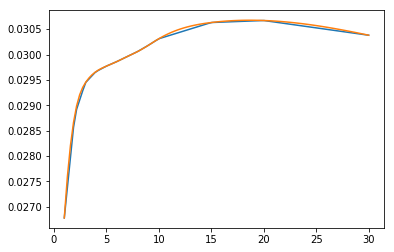

In [26]:
plt.plot(x_value, y_value(x_value))
plt.plot(x_value, y_value_c(x_value))

In [224]:
DF_obj.get_array_swap_rate()

[0.02678,
 0.028810000000000002,
 0.029439999999999997,
 0.029660000000000002,
 0.029769999999999998,
 0.02986,
 0.029960000000000004,
 0.030060000000000003,
 0.030180000000000002,
 0.030310000000000004,
 0.03063,
 0.03067,
 0.03038]

In [17]:
DF_obj.get_array_swap_tenor()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]

In [18]:
DF_obj.get_raw_rate('6M')

0.025305

In [19]:
DF_obj.calc_DF_short_term('6M')

0.9875055855784685

In [20]:
str_dcc_to_num('ACT/360')

360

In [21]:
tenor_to_days('1W')

7

### datetime

In [22]:
today_obj = datetime.datetime.now()
oneweek_obj = datetime.datetime.now() + datetime.timedelta(days=7)

In [23]:
(oneweek_obj -  today_obj).days

7

## list of error

In [268]:
df_IR[df_IR['Tenor']=='1M']['Rate'][0]

KeyError: 0